# Dataset 1 - CASAS (regressão linear)



In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#dataset download: https://drive.google.com/file/d/1uEaeLuSjuqjb-_OacKNwOKJnh1MtNJUP/view?usp=drive_link
caminho = '/content/drive/MyDrive/PC - UPLOAD/CIENCIA DE DADOS/Datasets aleatorios/Bancos de dados/sao-paulo-properties-april-2019.csv/sao-paulo-properties-april-2019.csv'
casas = pd.read_csv(caminho)

casas.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


## Selecionando os atributos

In [ ]:
casas['total'] = casas.Price + casas.Condo
casas = casas[casas['Negotiation Type'] == 'rent']
casas = casas.drop(columns = ['Price', 'Condo', 'District', 'Latitude', 'Longitude', 'Property Type', 'Negotiation Type'])

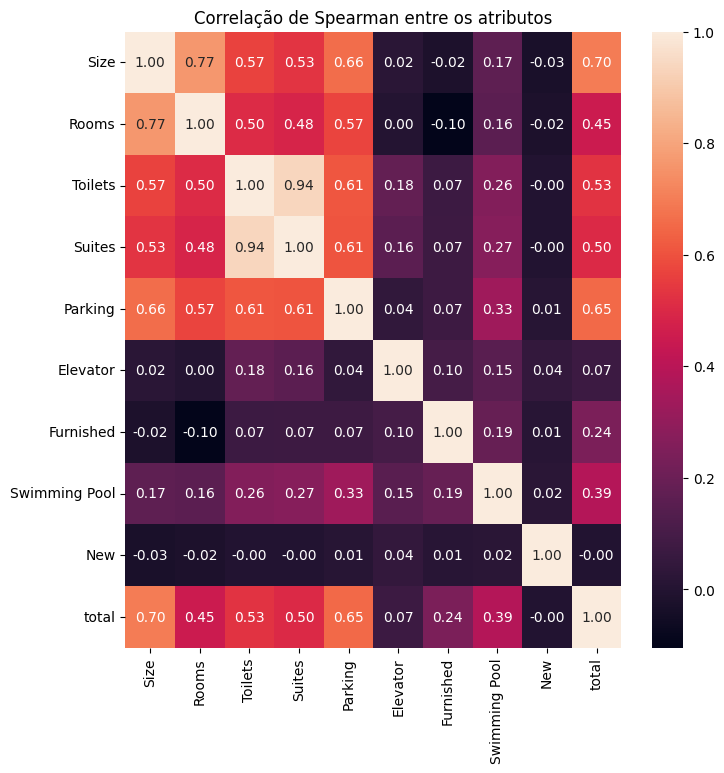

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
correlacao = casas.corr(method = 'spearman')

plt.figure(figsize=(8,8))
sns.heatmap(correlacao, annot = True, fmt = '.2f')
plt.title('Correlação de Spearman entre os atributos')
plt.show()

In [ ]:
melhores_atributos = ['Size', 'Parking', 'Toilets', 'Swimming Pool', 'total']
casas1 = casas[melhores_atributos]

In [ ]:
import altair as alt

amostra = casas1.sample(200, random_state = 1)

gr1 = alt.Chart(amostra).mark_point().encode(
    x = alt.X('Size:Q', axis = alt.Axis(title = 'Tamanho em m^2')),
    y = alt.Y('total:Q', axis = alt.Axis(title = 'Preço total do aluguel')),
    color = alt.Color('Swimming Pool:O', scale = alt.Scale(range = ['red', 'blue']))
).interactive()

gr2 = alt.Chart(amostra).mark_point().encode(
    x = alt.X('Parking:O', axis = alt.Axis(title = 'Número de vagas de estacionamento')),
    y = alt.Y('total:Q', axis = alt.Axis(title = 'Preço total do aluguel')),
    color = alt.Color('Swimming Pool:O', scale = alt.Scale(range = ['red', 'blue']))
).interactive().properties(width = 300)

gr1 | gr2

alt.HConcatChart(...)

## Realizando o pre-processamento

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
def outliers_removal(df, columns, threshold = 1.5):
    ouliers = 0
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

casas_processado = outliers_removal(casas1,casas1.columns)

In [ ]:
casas_processado['total'].max()

5856

In [ ]:
scaler = MinMaxScaler()
casas_scaled = scaler.fit_transform(casas_processado)
casas_scaled = pd.DataFrame(casas_scaled)
casas_scaled.columns = casas_processado.columns

In [ ]:
outliers = casas1[~casas1.index.isin(casas_processado.index)]
outliers.head()

,Size,Parking,Toilets,Swimming Pool,total
24,230,2,2,0,4393
33,150,2,4,0,6800
36,155,3,4,0,5250
81,105,2,4,1,4050
84,126,2,4,1,4530


## Aplicando Regressão Linear

In [ ]:
import numpy as np

data = casas_scaled

X = data.drop('total', axis = 1)
y = data['total'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

X_train = pd.DataFrame(X_train, columns  = X_train.columns)
X_test = pd.DataFrame(X_test, columns  = X_test.columns)

modelo = LinearRegression()

modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

n = X_test.shape[0]
p = X_test.shape[1]

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


print("Mean Squared Error (MSE):", mse.round(3))
print("Coeficiente de Determinação (R²):", r2.round(3))
print("Mean Absolute Error (MAE):", mae.round(2))
print("R² ajustado:", adj_r2.round(2))


Mean Squared Error (MSE): 0.024
Coeficiente de Determinação (R²): 0.459
Mean Absolute Error (MAE): 0.12
R² ajustado: 0.46


In [ ]:
scaler = MinMaxScaler()
y1 = scaler.fit(casas_processado['total'].values.reshape(-1,1))
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))

In [ ]:
y_teste_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
predito = pd.DataFrame(y_pred_original)
original = pd.DataFrame(y_teste_original)

am_pred = predito.sample(150)
am_orig = original[original.index.isin(am_pred.index)]

print(am_pred.info(), am_orig.info())

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 133 to 1234
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       150 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB
<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 7 to 1719
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       150 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB
None None


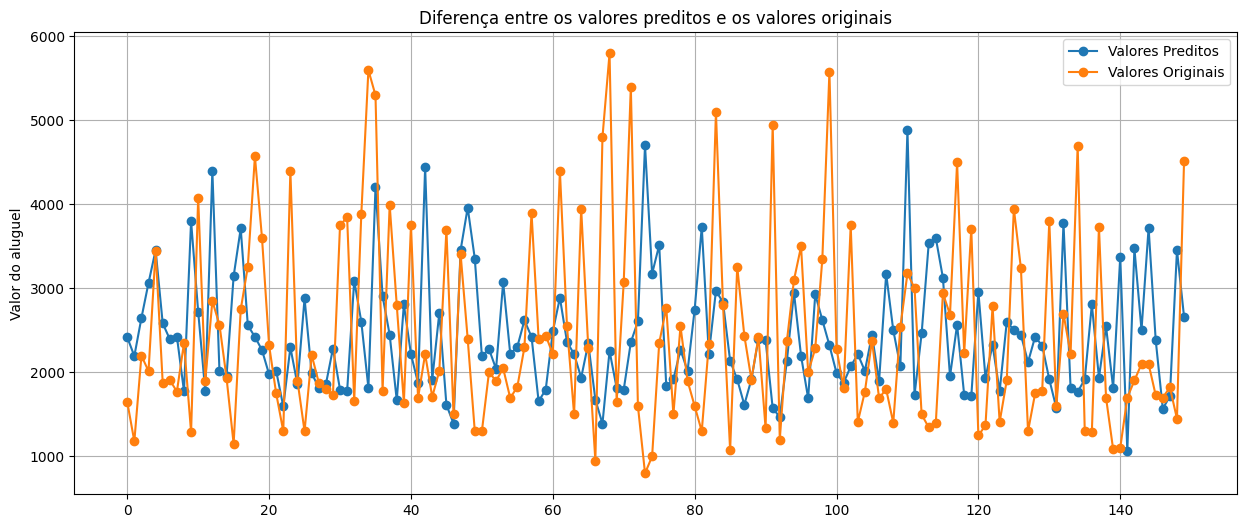

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(range(150), am_pred, marker='o', linestyle='-', label='Valores Preditos')
plt.plot(range(150), am_orig, marker='o', linestyle='-', label='Valores Originais')
#plt.xlabel('Elemento')
plt.ylabel('Valor do aluguel')
plt.title('Diferença entre os valores preditos e os valores originais')
plt.legend()  # Adiciona a legenda com os rótulos das linhas
plt.grid(True)
plt.show()

In [ ]:
print('Coeficientes angulares:', modelo.coef_)
print('Coeficiente linear da regressão:', modelo.intercept_)

Coeficientes angulares: [0.53300917 0.18214631 0.00874077 0.11783392]
Coeficiente linear da regressão: 0.10567754618639053


## Fazendo uma regressão um pouco mais simples, sem o MinMaxScaler

In [ ]:
data = casas_processado

X = data.drop('total', axis = 1)
y = data['total'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

X_train = pd.DataFrame(X_train, columns  = X_train.columns)
X_test = pd.DataFrame(X_test, columns  = X_test.columns)

modelo = LinearRegression()

modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

n = X_test.shape[0]
p = X_test.shape[1]

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


print("Mean Squared Error (MSE):", mse.round(3))
print("Coeficiente de Determinação (R²):", r2.round(3))
print("Mean Absolute Error (MAE):", mae.round(2))
print("R² ajustado:", adj_r2.round(2))

Mean Squared Error (MSE): 680338.984
Coeficiente de Determinação (R²): 0.459
Mean Absolute Error (MAE): 627.26
R² ajustado: 0.46


In [ ]:
predito = pd.DataFrame(y_pred)
am_pred = predito.sample(150)

In [ ]:
original = pd.DataFrame(y_test)
am_original = original[original.index.isin(am_pred.index)]

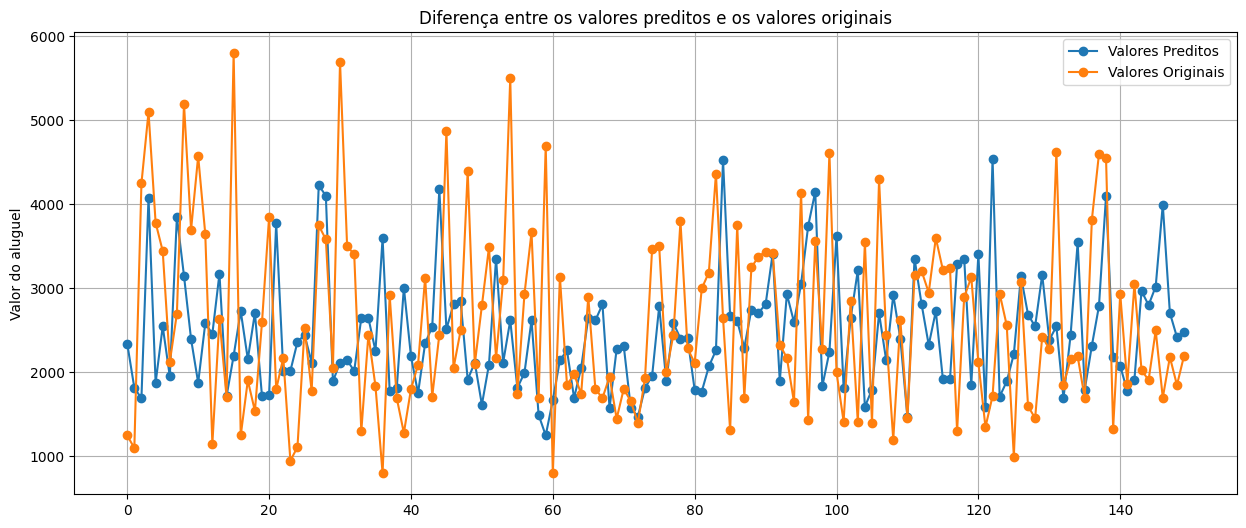

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(range(150), am_pred, marker='o', linestyle='-', label='Valores Preditos')
plt.plot(range(150), am_original, marker='o', linestyle='-', label='Valores Originais')
#plt.xlabel('Elemento')
plt.ylabel('Valor do aluguel')
plt.title('Diferença entre os valores preditos e os valores originais')
plt.legend()  # Adiciona a legenda com os rótulos das linhas
plt.grid(True)
plt.show()

# Dataset  2 - EXPECTATIVA DE VIDA (regressão linear)

## Importanto o dataset

In [ ]:
from vega_datasets import data
import altair as alt
import pandas as pd
import numpy as np

In [ ]:
gm = data.gapminder()
#gm['year'] = pd.to_datetime(gm['year'], format = '%Y')
gm.head()

,year,country,cluster,pop,life_expect,fertility
0,1955,Afghanistan,0,8891209,30.332,7.7
1,1960,Afghanistan,0,9829450,31.997,7.7
2,1965,Afghanistan,0,10997885,34.020,7.7
3,1970,Afghanistan,0,12430623,36.088,7.7
4,1975,Afghanistan,0,14132019,38.438,7.7


In [ ]:
for i in range(0,6):
  lista = gm[gm.cluster == i]['country'].unique()
  print(lista)

gm['Região'] = gm.cluster

['Afghanistan' 'Bangladesh' 'India' 'Pakistan']
['Austria' 'Belgium' 'Croatia' 'Finland' 'France' 'Georgia' 'Germany'
 'Greece' 'Iceland' 'Ireland' 'Italy' 'Netherlands' 'Norway' 'Poland'
 'Portugal' 'Spain' 'Switzerland' 'Turkey' 'United Kingdom']
['Kenya' 'Nigeria' 'Rwanda' 'South Africa']
['Argentina' 'Aruba' 'Bahamas' 'Barbados' 'Bolivia' 'Brazil' 'Canada'
 'Chile' 'Colombia' 'Costa Rica' 'Cuba' 'Dominican Republic' 'Ecuador'
 'El Salvador' 'Grenada' 'Haiti' 'Jamaica' 'Mexico' 'Peru' 'United States'
 'Venezuela']
['Australia' 'China' 'Hong Kong' 'Indonesia' 'Japan' 'South Korea'
 'North Korea' 'New Zealand' 'Philippines']
['Egypt' 'Iran' 'Iraq' 'Israel' 'Lebanon' 'Saudi Arabia']


In [ ]:
def continente(linha):
  if linha['Região'] == 0 or linha['Região'] == 5:
    return 'Oriente Médio'
  if linha['Região'] == 1:
    return 'Europa'
  if linha['Região'] == 2:
    return 'África'
  if linha['Região'] == 3:
    return 'América Latina'
  if linha['Região'] == 4:
    return 'Ásia'
gm['Região'] = gm.apply(lambda linha: continente(linha), axis = 1)

In [ ]:
gm2005 = gm[gm.year == 2005]

## Visualizando os dados do dataset utilizando Vega Altair

In [ ]:
selecao = alt.selection_single(fields=['Região'], empty = 'none')

linhas = alt.Chart(gm).mark_line().encode(
    x = 'year:T',
    y = alt.Y('average(life_expect):Q', scale = alt.Scale(zero = False)),
    color= 'Região:N'
)

pontos = alt.Chart(gm).mark_circle().encode(
    x = 'year:T',
    y = alt.Y('average(life_expect):Q', scale = alt.Scale(zero = False)),
    color='Região:N'
)

final_linhas = (linhas + pontos).add_selection(selecao).encode(
    tooltip = ['year','average(life_expect)','Região'],
    x = alt.X(axis = alt.Axis(title = 'Ano')),
    y = alt.Y(axis = alt.Axis(title = 'Expectativa de vida média'))
)

barras = alt.Chart(gm).mark_bar().encode(
    y = alt.Y('country', axis = alt.Axis(title = 'País')),
    x = alt.X('life_expect', axis = alt.Axis(title = 'Expectativa de vida em 2005')),
    tooltip = ['country', 'life_expect', 'year']
).transform_filter(
    selecao
).properties(
    height = 300)

texto_barras = alt.Chart(gm2005).mark_text(
    dx = 30,
    color = 'red'
).encode(
    y = 'country:N',
    x = 'life_expect:Q',
    text = 'life_expect:Q'
).transform_filter(
    selecao
).properties(
    height = 300)

'''
texto_barras = barras.mark_text(
    dy = -10,
    color = 'red'
).encode(
    text = 'life_expect'
)
'''
final_barras = (barras + texto_barras).transform_filter(
    selecao
).properties(
    height = 300)

final_total = alt.hconcat(final_linhas, final_barras)

final_total

alt.HConcatChart(...)

## Fazendo uma regressão linear para prever o ano em que a expectativa de vida na América Latina supera a da Europa

In [ ]:
data = pd.DataFrame(gm.groupby(['Região','year'])['life_expect'].mean().reset_index())
data = data[data['Região'].isin(['América Latina', 'Europa'])]

#Cria um dataframe a partir do anterior apenas com as regiões América Latina e Europa.
#O atributo 'life_expect' será a média das expectativas de vida em cada região.

data_eu = data[data['Região'] == 'Europa']
data_latam = data[data['Região'] == 'América Latina']

#Separa em dois dataframes distintos os dados para Europa e América Latina.
#Isso será útil para a comparação das expectativas de vida nos próximos anos.

In [ ]:
#Abaixo, vamos desenhar os gráficos com os dados temporais para expectativa de vida em cada região

grafico  = (

alt.Chart(data).mark_line().encode(
    x = 'year',
    y = alt.Y('life_expect', scale = alt.Scale(zero = False)),
    color = 'Região'
)

+

alt.Chart(data).mark_point().encode(
    x = 'year',
    y = alt.Y('life_expect', scale = alt.Scale(zero = False)),
    color = 'Região'
)

).encode(
    tooltip = ['year', 'life_expect']
)

grafico

alt.LayerChart(...)

In [ ]:
print('Correlação entre expectativa de vida e o tempo para Latam\n', data_latam.drop('Região', axis = 1).corr(),'\n')

print('Correlação entre expectativa de vida e o tempo para Europa\n', data_eu.drop('Região', axis = 1).corr())

Correlação entre expectativa de vida e o tempo para Latam
                  year  life_expect
year         1.000000     0.994098
life_expect  0.994098     1.000000 

Correlação entre expectativa de vida e o tempo para Europa
                  year  life_expect
year         1.000000     0.998963
life_expect  0.998963     1.000000


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### Regressão para América Latina (LATAM)

In [ ]:
X = np.array(data_latam['year']).reshape(-1, 1)
y = (data_latam['life_expect'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

modelo_latam = LinearRegression()

modelo_latam.fit(X_train, y_train)
y_pred = modelo_latam.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print("Mean Squared Error (MSE):", mse.round(3))
print("Coeficiente de Determinação (R²):", r2.round(3))
print("Mean Absolute Error (MAE):", mae.round(2))

Mean Squared Error (MSE): 0.227
Coeficiente de Determinação (R²): 0.987
Mean Absolute Error (MAE): 0.46


In [ ]:
print('Coeficiente Linear Regressão Latam:', modelo_latam.coef_)

print('Coeficiente Linear Regressão Latam:', round(modelo_latam.intercept_,2))

Coeficiente Linear Regressão Latam: [0.34052845]
Coeficiente Linear Regressão Latam: -607.98


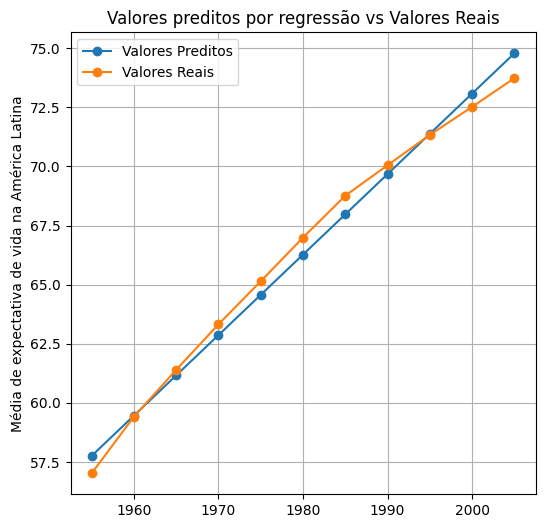

In [ ]:
import matplotlib.pyplot as plt

predito = modelo_latam.coef_*X + modelo_latam.intercept_

gr_latam = (
plt.figure(figsize = (6,6)),
plt.plot(X, predito, marker='o', linestyle='-', label='Valores Preditos'),
plt.plot(X, y, marker='o', linestyle='-', label='Valores Reais'),
plt.ylabel('Média de expectativa de vida na América Latina'),
plt.title('Valores preditos por regressão vs Valores Reais'),
plt.legend(),
plt.grid(True)
)

### Regressão para a região da Europa

In [ ]:
#Regressão EUROPA

X_eu = np.array(data_eu['year']).reshape(-1, 1)
y_eu = (data_eu['life_expect'])

X_train, X_test, y_train, y_test = train_test_split(X_eu, y_eu, test_size = 0.3, random_state = 1)

modelo_eu = LinearRegression()

modelo_eu.fit(X_train, y_train)
y_pred_eu = modelo_eu.predict(X_test)

mse = mean_squared_error(y_test, y_pred_eu)
r2 = r2_score(y_test, y_pred_eu)
mae = mean_absolute_error(y_test, y_pred_eu)


print("Mean Squared Error (MSE):", mse.round(3))
print("Coeficiente de Determinação (R²):", r2.round(3))
print("Mean Absolute Error (MAE):", mae.round(2))

Mean Squared Error (MSE): 0.03
Coeficiente de Determinação (R²): 0.997
Mean Absolute Error (MAE): 0.14


In [ ]:
print('Coeficiente Linear Regressão Latam:', modelo_eu.coef_)

print('Coeficiente Linear Regressão Latam:', round(modelo_eu.intercept_,2))

Coeficiente Linear Regressão Latam: [0.22560479]
Coeficiente Linear Regressão Latam: -373.56


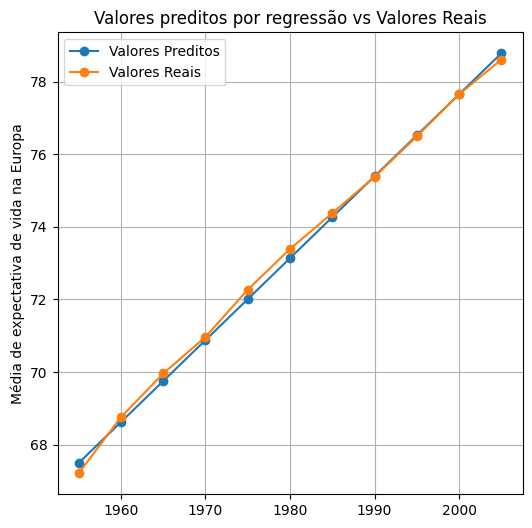

In [ ]:
predito_eu = modelo_eu.coef_*X + modelo_eu.intercept_

gr_eu = (
plt.figure(figsize = (6,6)),
plt.plot(X_eu, predito_eu, marker='o', linestyle='-', label='Valores Preditos'),
plt.plot(X_eu, y_eu, marker='o', linestyle='-', label='Valores Reais'),
plt.ylabel('Média de expectativa de vida na Europa'),
plt.title('Valores preditos por regressão vs Valores Reais'),
plt.legend(),
plt.grid(True)
)

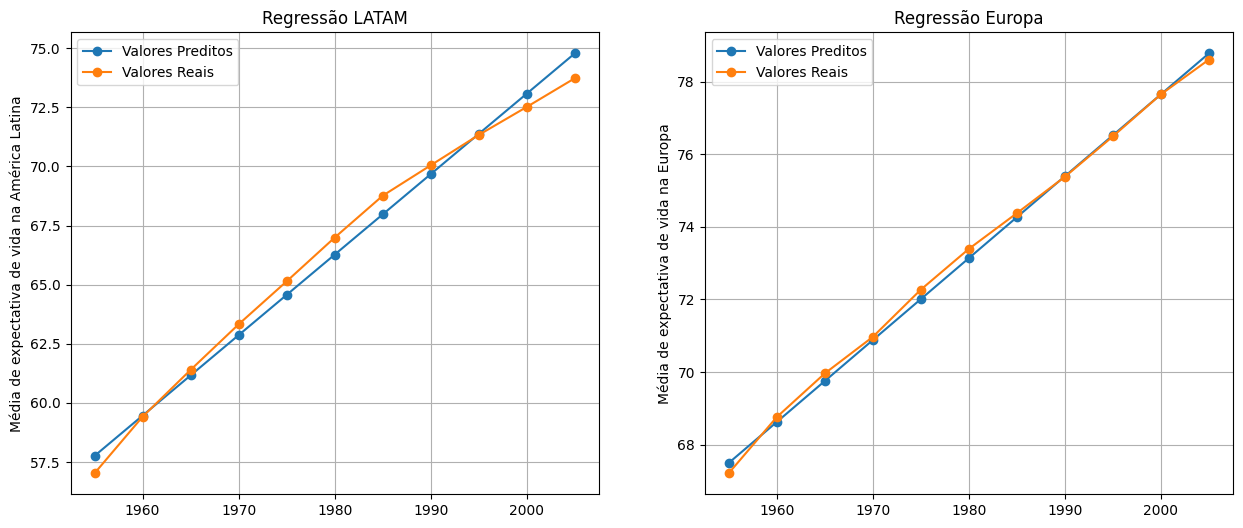

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(X, predito, marker='o', linestyle='-', label='Valores Preditos'),
plt.plot(X, y, marker='o', linestyle='-', label='Valores Reais'),
plt.ylabel('Média de expectativa de vida na América Latina'),
plt.title('Regressão LATAM'),
plt.legend(),
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(X_eu, predito_eu, marker='o', linestyle='-', label='Valores Preditos'),
plt.plot(X_eu, y_eu, marker='o', linestyle='-', label='Valores Reais'),
plt.ylabel('Média de expectativa de vida na Europa'),
plt.title('Regressão Europa'),
plt.legend(),
plt.grid(True)

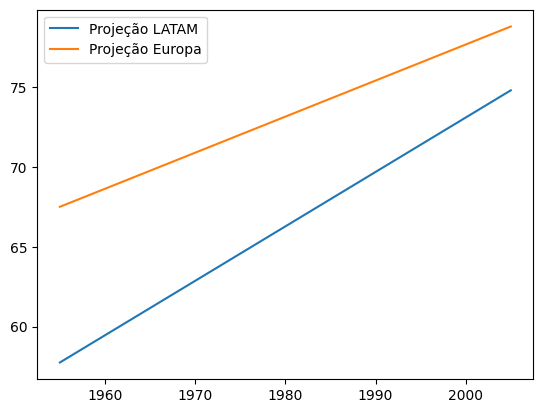

In [ ]:
plt.plot(X, predito, label = 'Projeção LATAM')
plt.plot(X, predito_eu, label = 'Projeção Europa')
plt.legend()

### Calculando o ano em que as retas se encontram (i.e.: as expectativas de vida se igualam)

In [ ]:
ano_encontro = (modelo_latam.intercept_ - modelo_eu.intercept_)/(modelo_eu.coef_ - modelo_latam.coef_)
ano_encontro1 = int(ano_encontro[0]//1)
print('O ano em que as expectativas de vida se igualam é:', ano_encontro1)

O ano em que as expectativas de vida se igualam é: 2039


In [ ]:
valor_2039 = modelo_latam.coef_*ano_encontro + modelo_latam.intercept_
valor_2039
#Calcula qual será a expectativa de vida média nas regiões no ano em que se igualarem

array([86.61767012])

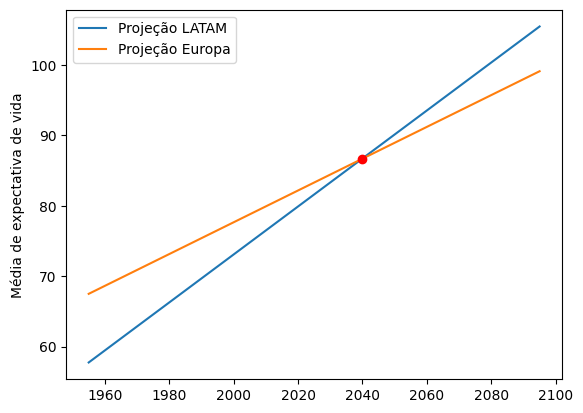

In [ ]:
x1 = range(1955,2105, 10)

predito_latam = modelo_latam.coef_*x1 + modelo_latam.intercept_
predito_eu1 = modelo_eu.coef_*x1 + modelo_eu.intercept_

plt.plot(x1, predito_latam, linestyle='-', label='Projeção LATAM'),
plt.plot(x1, predito_eu1, linestyle='-', label='Projeção Europa'),
plt.scatter(ano_encontro, valor_2039, color = 'red',  zorder=5)
plt.ylabel('Média de expectativa de vida'),
plt.legend()

# Dataset 3: Bank Marketing (Regressão logística)

## Importando o conjunto de dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
#data download: https://drive.google.com/file/d/1ePazMByUtHFDxFyoO8sXOK2fbmqxQ594/view?usp=sharing
data = pd.read_csv('/content/drive/MyDrive/PC - UPLOAD/CIENCIA DE DADOS/Datasets aleatorios/bank-full.csv', sep = ';')

In [ ]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
data.loc[data['y'] == 'no', 'y'] = 0
data.loc[data['y'] == 'yes', 'y'] = 1

In [ ]:
data.y.value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [ ]:
#Retirando alguns atributos categóricos e trocando 'no' para 0 e 'yes' para 1 em todo o dataset

data1 = data.drop(columns =
['job', 'marital', 'education', 'contact', 'day', 'month', 'duration', 'pdays', 'previous', 'poutcome']
)

def no_to_zero(data):
  data = data.replace({'no': 0, 'yes': 1})
  return data

data = no_to_zero(data1)
data

,age,default,balance,housing,loan,campaign,y
0,58,0,2143,1,0,1,0
1,44,0,29,1,0,1,0
2,33,0,2,1,1,1,0
3,47,0,1506,1,0,1,0
4,33,0,1,0,0,1,0
...,...,...,...,...,...,...,...
45206,51,0,825,0,0,3,1
45207,71,0,1729,0,0,2,1
45208,72,0,5715,0,0,5,1
45209,57,0,668,0,0,4,0


## Aplicando a regressão logística



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sn

In [ ]:
X = data.drop('y', axis = 1)
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

## Penalidade L1

In [ ]:
modelo_L1 = LogisticRegression(penalty = 'l1', solver='liblinear', max_iter = 1000)
modelo_L1.fit(X_train, y_train)
y_pred_L1 = modelo_L1.predict(X_test)
accuracy_L1 = accuracy_score(y_test, y_pred_L1)
print(f'Acurácia com penalidade L1: {accuracy_L1}')

Acurácia com penalidade L1: 0.8854320259510469


In [ ]:
relatorio = classification_report(y_test, y_pred_L1)
print(relatorio)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     12013
           1       0.00      0.00      0.00      1551

    accuracy                           0.89     13564
   macro avg       0.44      0.50      0.47     13564
weighted avg       0.78      0.89      0.83     13564



<Axes: xlabel='Predito', ylabel='Esperado'>

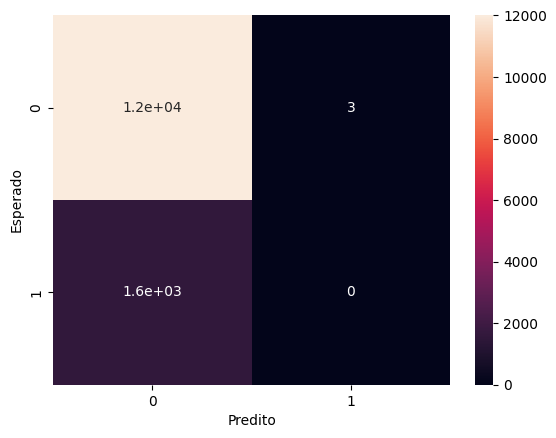

In [ ]:
import seaborn as sn

confusion_matrix = pd.crosstab(y_test, y_pred_L1, rownames=['Esperado'], colnames=['Predito'])
sn.heatmap(confusion_matrix, annot=True)

## Penalidade L2

In [ ]:
modelo_L2 = LogisticRegression(penalty = 'l2', max_iter = 1000)
modelo_L2.fit(X_train, y_train)
y_pred_L2 = modelo_L2.predict(X_test)
accuracy_L2 = accuracy_score(y_test, y_pred_L2)
print(f'Acurácia com penalidade L2: {accuracy_L2}')

Acurácia com penalidade L2: 0.8854320259510469


In [ ]:
relatorio = classification_report(y_test, y_pred_L2)
print(relatorio)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     12013
           1       0.00      0.00      0.00      1551

    accuracy                           0.89     13564
   macro avg       0.44      0.50      0.47     13564
weighted avg       0.78      0.89      0.83     13564



<Axes: xlabel='Predito', ylabel='Esperado'>

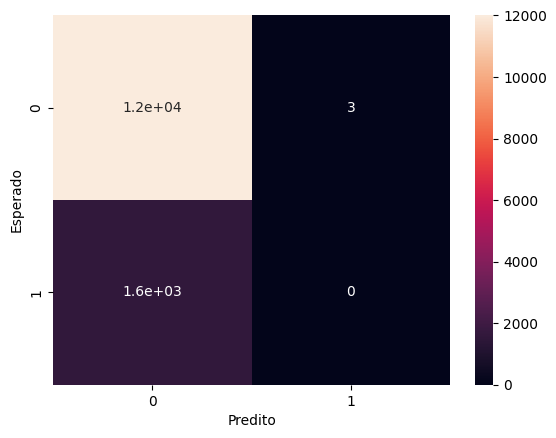

In [ ]:
confusion_matrix = pd.crosstab(y_test, y_pred_L1, rownames=['Esperado'], colnames=['Predito'])
sn.heatmap(confusion_matrix, annot=True)